# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам


# <center>Визуальный анализ данных и построение признаков

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from math import ceil

In [2]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(15, 5)}
        )

In [3]:
PATH_TO_DATA = os.path.expanduser('~/git_exercise/Coursera_ML_MFTI_Yandex/My_exercises/Course_6/capstone_user_identification/') 

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

In [5]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
        
    df_list = []
    
    user_ids = []
    for file in tqdm(sorted(glob(f'{path_to_csv_files}/*.csv'))):
        z = pd.read_csv(f'{file}', parse_dates=[0])        
        
        number_of_sessions = ceil(z.site.size / window_size)      
        for index, i in enumerate(range(number_of_sessions)):
            current_size = z.site.size - index*window_size
            df_list_temp = [freq_dict[z.site[x + index*window_size]][0] 
                            if (x < current_size) else 0 for x in range(session_length)]
            if 0 in df_list_temp:
                unique = np.unique(df_list_temp, return_counts=True)[1].size - 1
            else:
                unique = np.unique(df_list_temp, return_counts=True)[1].size
            
            times = [int((z.timestamp[q+1 + index*window_size] - z.timestamp[q + index*window_size]) 
                         / np.timedelta64(1, 's')) if (q < current_size - 1) else 0  for q in range(session_length-1)]
            
            df_list_temp.extend(times)
            df_list_temp.extend([sum(times), unique, 
                                 z.timestamp[0 + index*window_size].hour, 
                                 z.timestamp[0 + index*window_size].weekday(),
                                 None])          
            
            df_list.append(df_list_temp)           

            user_ids.append(int(file[-8:-4]))
            
    df = pd.DataFrame(data=df_list, index = [x+1 for x in range(len(df_list))], columns=feature_names)
    df['target'] = user_ids
    
    return df

**Проверим функцию на игрушечном примере.**

In [6]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████| 3/3 [00:00<00:00, 59.54it/s]


In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
1,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
2,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
3,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
4,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
5,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [8]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
1,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
2,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
3,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
4,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
5,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                                               session_length=10, 
                                               feature_names=feature_names)

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]

CPU times: user 28.6 s, sys: 101 ms, total: 28.7 s
Wall time: 29.4 s


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
1,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
2,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
3,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
4,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
5,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [11]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                                               site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                                               session_length=10, 
                                               feature_names=feature_names)

100%|██████████| 150/150 [04:23<00:00,  1.76s/it]


CPU times: user 4min 24s, sys: 853 ms, total: 4min 25s
Wall time: 4min 24s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features_10users = train_data_10users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [13]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради дадим пользователям имена и ассоциируем с ними цвета.**

In [14]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [15]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

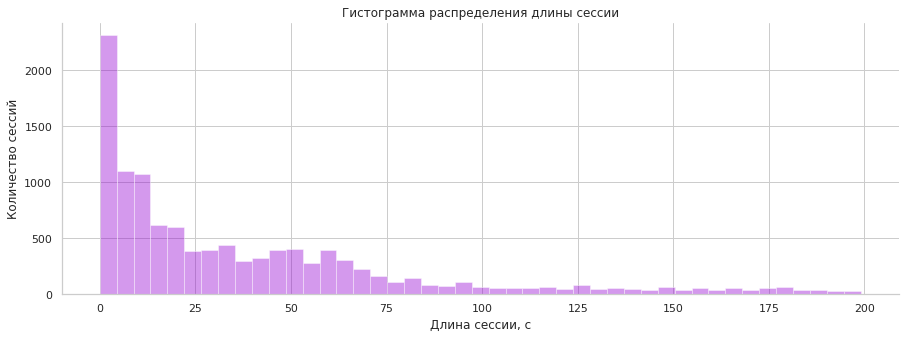

In [16]:
ax = sns.distplot(train_data_10users[train_data_10users['session_timespan'] < 200].session_timespan,
                  kde=False, color='darkviolet')

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Длина сессии, с') 
ax.set_title('Гистограмма распределения длины сессии')  # Title of the plot

sns.despine()  # Get rid of axis on the plot

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

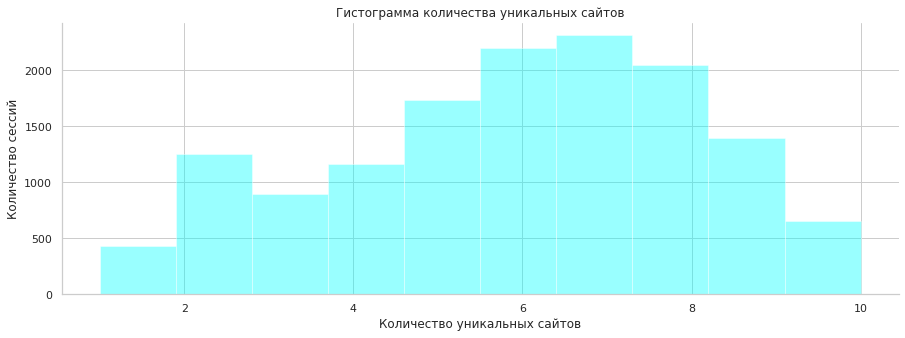

In [17]:
ax = sns.distplot(train_data_10users['#unique_sites'], kde=False, color='aqua', bins=10)

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Количество уникальных сайтов')  
ax.set_title('Гистограмма количества уникальных сайтов')  # Title of the plot

sns.despine()  # Get rid of axis on the plot

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

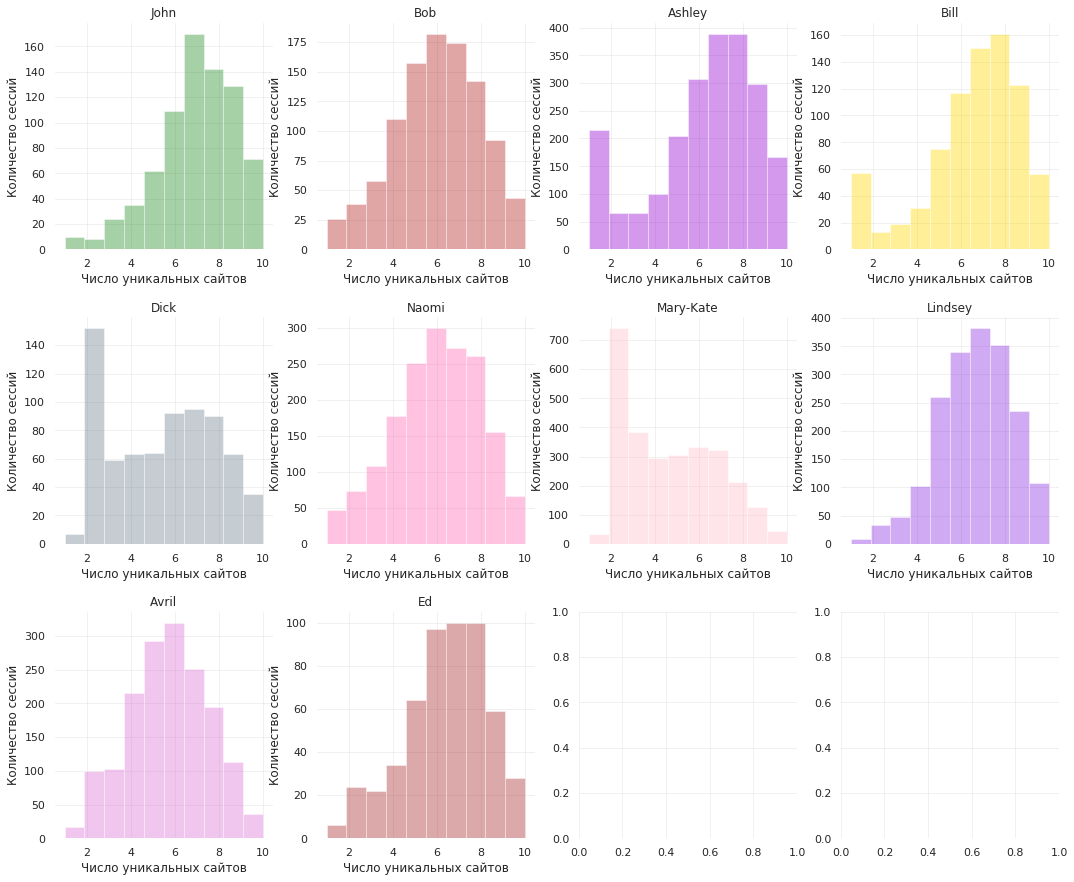

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in train_data_10users.target.unique()],
                             [train_data_10users.query('target == @t') for t in train_data_10users.target.unique()]):
    sns.distplot(sub_df['#unique_sites'], kde=False, color=color_dic[user], bins=10, ax=ax)
    
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('Число уникальных сайтов') 
    
plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

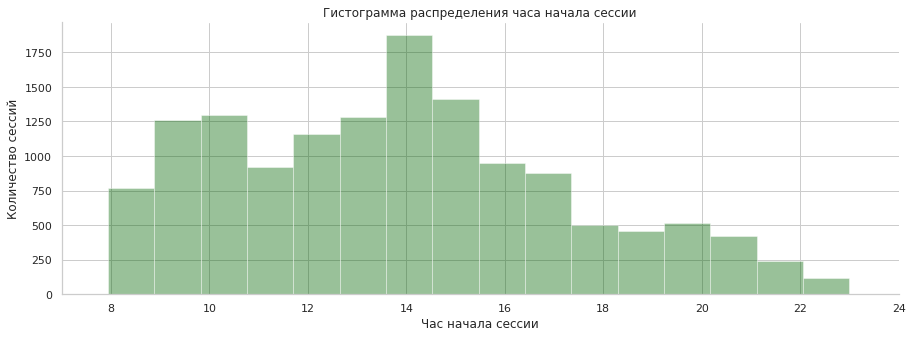

In [19]:
ax = sns.distplot(train_data_10users['start_hour'], kde=False, color='darkgreen', 
                  bins=train_data_10users['start_hour'].unique().size)

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Час начала сессии')  
ax.set_title('Гистограмма распределения часа начала сессии')  # Title of the plot
plt.xlim(7, 24)

sns.despine()  # Get rid of axis on the plot

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

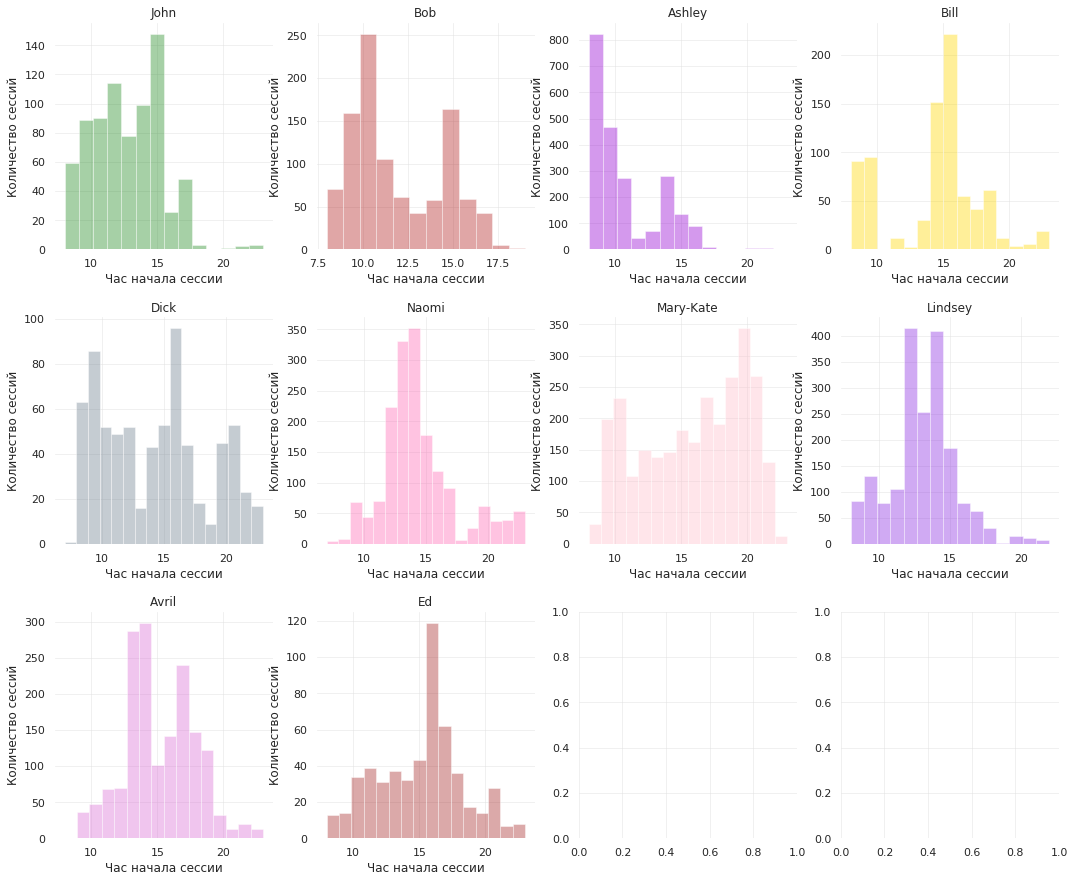

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in train_data_10users.target.unique()],
                             [train_data_10users.query('target == @t') for t in train_data_10users.target.unique()]): 
    sns.distplot(sub_df['start_hour'], kde=False, color=color_dic[user], 
                 bins=sub_df['start_hour'].unique().size, ax=ax)
    
    
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('Час начала сессии')     
    
plt.show()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

#### Примечание: с днями недели столбчатый график показался красивее, чем гистограмма

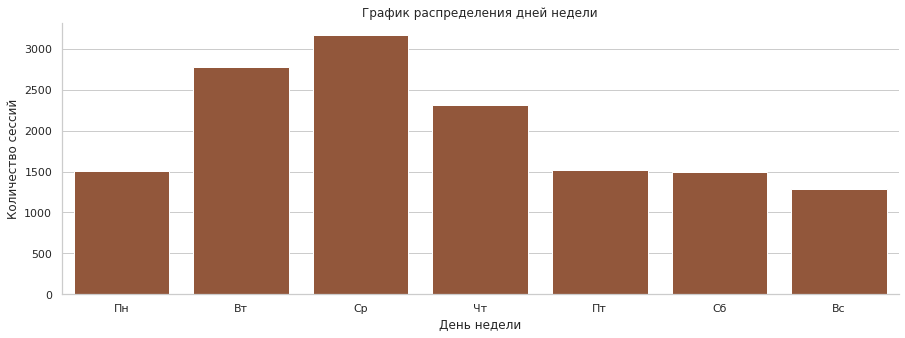

In [21]:
ax = sns.countplot(train_data_10users['day_of_week'], color='sienna')

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('День недели')  
ax.set_title('График распределения дней недели')  # Title of the plot

ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

sns.despine()  # Get rid of axis on the plot

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

In [22]:
days_dict = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}

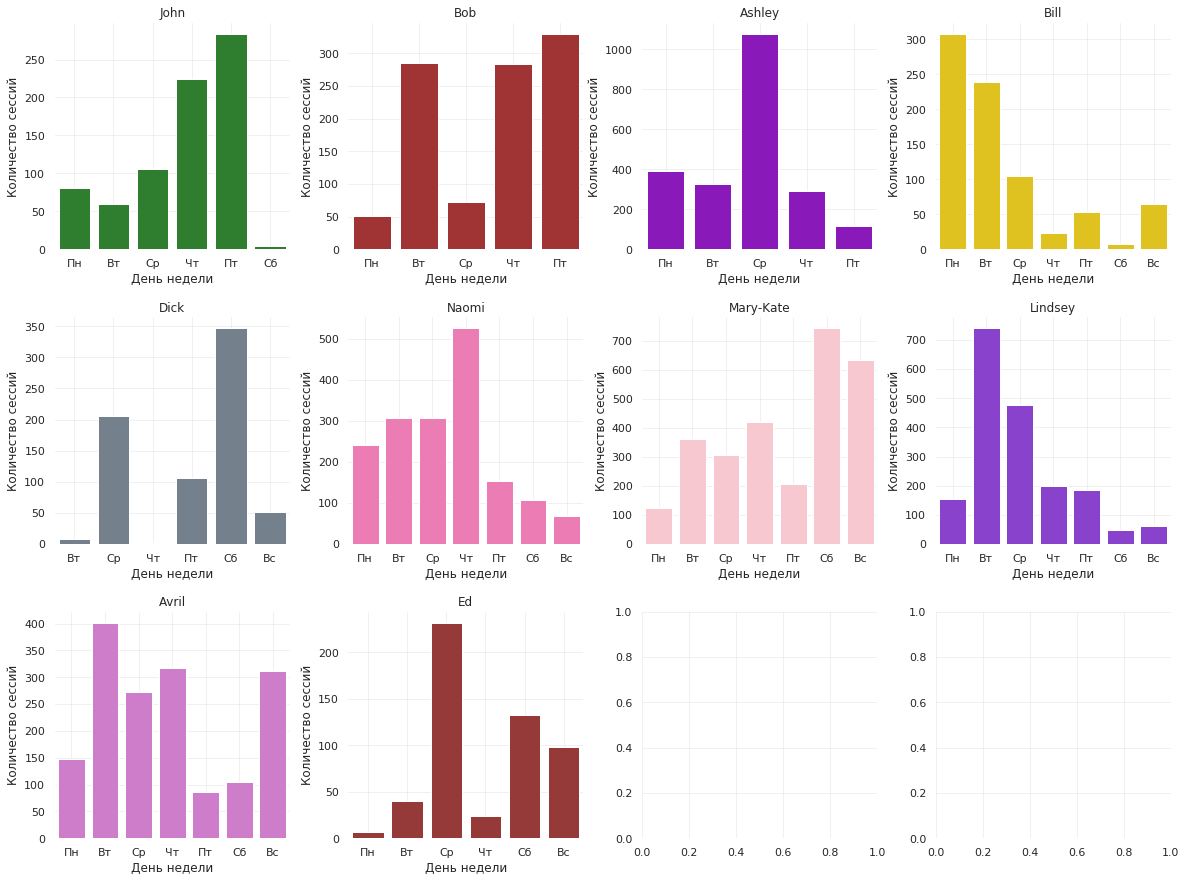

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in train_data_10users.target.unique()],
                             [train_data_10users.query('target == @t') for t in train_data_10users.target.unique()]): 
    sns.countplot(sub_df['day_of_week'], color=color_dic[user], ax=ax)
    
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.25, hspace=0.3)

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('День недели') 
    indexes = train_data_10users[train_data_10users.target == name].day_of_week.value_counts(sort=False).index.sort_values()
    ax.set_xticklabels([days_dict[x] for x in indexes])   
    
    
plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

John: Чаще посещает 6-9 уникальных сайтов. Активные часы - утро и день, до 15. Количество посещений растет к выходным, хотя на выходных практически нет сессий.

Bob: Чаще посещает 4-9 уникальных сайтов. Наиболее активное время - около 10 и около 15 часов. Наиболее активные дни - вторник, четверг, пятница. На выходных нет сессий.

Ashley: Чаще посещает 4-10 уникальных сайтов, хотя нередко всего один сайт. Основная активность - до 11 утра. Самый активный день - среда. На выходных нет сессий.

Bill: Чаще посещает 4-10 уникальных сайтов, хотя нередко всего один сайт. Чаще всего сессии между 14 и 16 часами. Наибольшая активность - в начале недели, к концу падает.

Dick: Чаще посещает 2 уникальных сайта и равномерно от 3 до 10. Примерно равномерная активность в течение дня. Самые активные дни - среда и суббота.

Naomi: Чаще посещает 4-9 уникальных сайтов. Чаще всего сессии между 12 и 18 часами. Активность растет с понедельника по четверг, потом падает.

Mary-Kate: Чаще посещает 2 уникальных сайта и равномерно от 3 до 8. Активность растет в течение дня и достигает максимума к вечеру. Активность растет в течение недели и достигает максимума в выходные.

Lindsey: Чаще посещает 5-9 уникальных сайтов. Чаще всего сессии между 12 и 15 часами. Самый активный день - вторник, потом активность постепенно падает.

Avril: Чаще посещает 4-8 уникальных сайтов. Чаще всего сессии между 13 и 19 часами. Примерно равномерная активность в течение недели, только в пятницу и субботу не так много сессий.

Ed: Чаще посещает 5-9 уникальных сайтов. Наибольшая активность около 16 часов. В остальное время - достаточно низкая. Наиболее активные дни - среда, суббота и воскресенье. В остальные дни существенно меньше посещений.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [24]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq_10users = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [25]:
top10 = sorted(site_freq_10users.items(), key=lambda item: item[1][0])[:10]
top10 

[('s.youtube.com', (1, 8300)),
 ('www.google.fr', (2, 7813)),
 ('www.google.com', (3, 5441)),
 ('mail.google.com', (4, 4158)),
 ('www.facebook.com', (5, 4141)),
 ('apis.google.com', (6, 3758)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (7, 3244)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (8, 3094)),
 ('plus.google.com', (9, 2630)),
 ('accounts.google.com', (10, 2089))]

In [26]:
top10_freqs = np.array(list(np.array(top10)[:, 1]))[:, 1]
top10_sites = np.array(top10)[:, 0]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

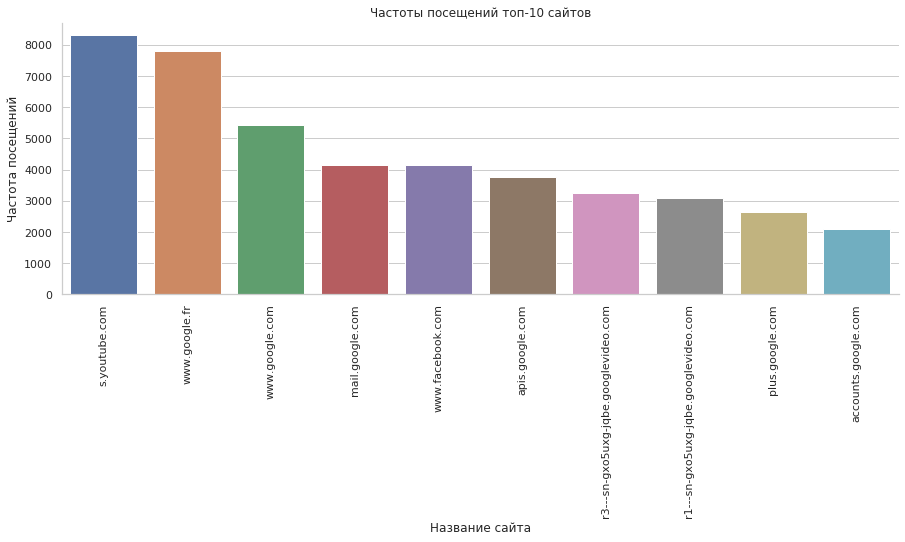

In [27]:
ax = sns.barplot(x=top10_sites, y=top10_freqs)

ax.set_ylabel('Частота посещений') 
ax.set_xlabel('Название сайта') 
ax.set_title('Частоты посещений топ-10 сайтов')  # Title of the plot
plt.xticks(rotation=90)


sns.despine()  # Get rid of axis on the plot

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [30]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [31]:
train_data_10users.day_of_week.median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [32]:
train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [33]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [32]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    
    
    with open(site_freq_path, 'rb') as f:
        freq_dict = pickle.load(f)
        
    df_list = []
        
    youtube_nums = []
    for key in freq_dict.keys():
        if 'youtube.com' in key:
            youtube_nums.append(freq_dict[key][0])
    
    user_ids = []
    for file in tqdm(sorted(glob(f'{path_to_csv_files}/*.csv'))):
        z = pd.read_csv(f'{file}', parse_dates=[0])         
        
        number_of_sessions = ceil(z.site.size / window_size)      
        for index, i in enumerate(range(number_of_sessions)):
            current_size = z.site.size - index*window_size
            df_list_temp = [freq_dict[z.site[x + index*window_size]][0] 
                            if (x < current_size) else 0 for x in range(session_length)]
            
            youtube_freq = []
            current_youtubes = 0
            for site in df_list_temp:
                if site in youtube_nums:
                    current_youtubes += 1
            youtube_freq.append(current_youtubes)
            
            df_list_temp = youtube_freq
                        
            times = [int((z.timestamp[q+1 + index*window_size] - z.timestamp[q + index*window_size]) 
                         / np.timedelta64(1, 's')) if (q < current_size - 1) else 0  for q in range(session_length-1)]
 
            df_list_temp.extend([max(times), 
                                 z.timestamp[0 + index*window_size].month,
                                 z.timestamp[0 + index*window_size].day])
                  
            df_list.append(df_list_temp)           

            user_ids.append(int(file[-8:-4]))
            
    df = pd.DataFrame(data=df_list, index = [x+1 for x in range(len(df_list))], columns=feature_names)
    df['target'] = user_ids
    
    return df

In [33]:
feature_names_new = ['youtube_visits', 'max_time', 'month', 'day']

new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                          site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                                          feature_names=feature_names_new, 
                                          session_length=10)

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


In [34]:
new_features_10users.head()

,youtube_visits,max_time,month,day,target
1,0,20,11,15,31
2,0,163,11,15,31
3,0,242,11,15,31
4,0,25,11,15,31
5,0,1,11,15,31


In [35]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                          site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                                          feature_names=feature_names_new, 
                                          session_length=10)

100%|██████████| 150/150 [03:54<00:00,  1.56s/it]


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

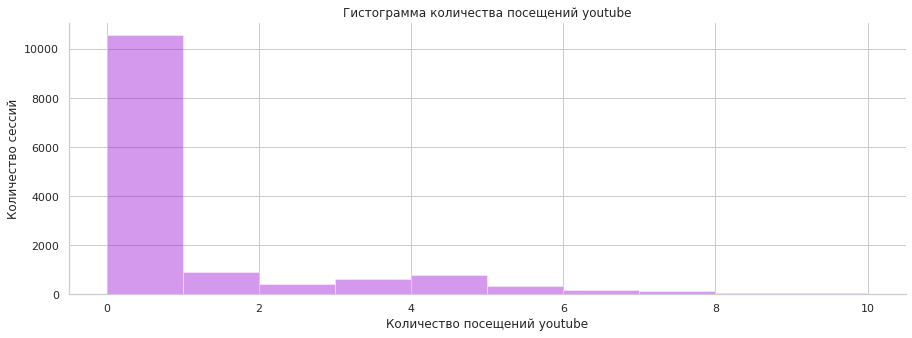

In [36]:
ax = sns.distplot(new_features_10users['youtube_visits'], kde=False, color='darkviolet', bins=10)
ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Количество посещений youtube')  
ax.set_title('Гистограмма количества посещений youtube')  # Title of the plot

sns.despine()  # Get rid of axis on the plot

In [37]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

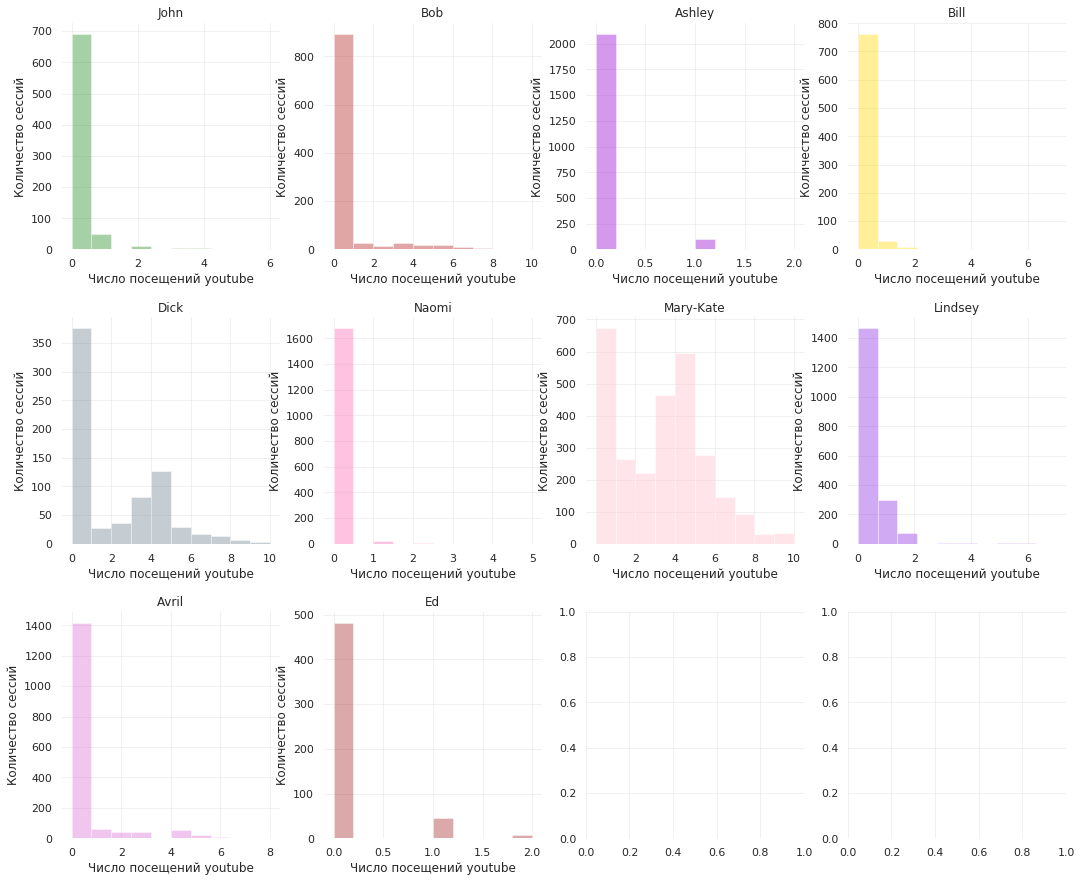

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in new_features_10users.target.unique()],
                             [new_features_10users.query('target == @t') for t in new_features_10users.target.unique()]):
    sns.distplot(sub_df['youtube_visits'], kde=False, color=color_dic[user], bins=10, ax=ax)
        
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('Число посещений youtube') 
    
plt.show()

#### Вывод: для некоторых пользователей (Dick, Mary-Kate) количество сессий с числом посещений youtube 3-5 составляет значительную долю от всех сессий. Тогда как большинство пользователей посещают youtube не так часто и обычно 1-2 раза.


Для анализа пользователей по максимальной длине сессии я разделил максимальные длины на 4 категории в соответствии с персентилями. Короткие - до 25%, Средние - до 50%, Длинные - до 75%, Очень длинные - до 100%. 

In [61]:
new_features_10users.max_time.describe()

count    1.406100e+04
mean     7.876277e+03
std      9.002585e+04
min      0.000000e+00
25%      4.000000e+00
50%      1.400000e+01
75%      6.400000e+01
max      5.812677e+06
Name: max_time, dtype: float64

In [76]:
max_time_cat, bins = pd.qcut(new_features_10users.max_time, 4, 
                         labels=['Короткие', 'Средние', 'Длинные', 'Очень длинные'], retbins=True)

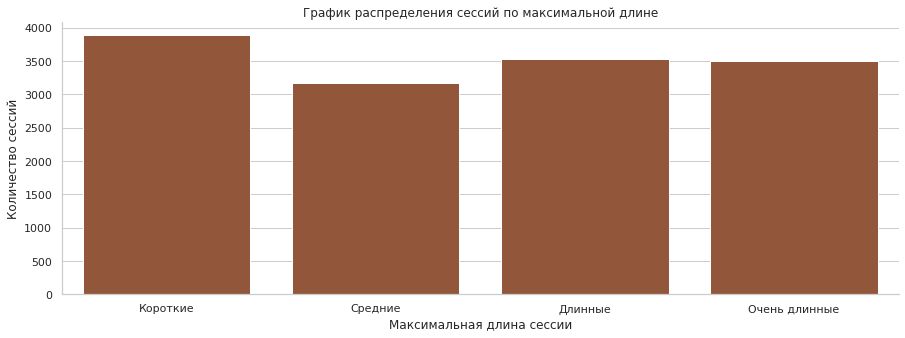

In [77]:
ax = sns.countplot(max_time_cat, color='sienna')

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Максимальная длина сессии')  
ax.set_title('График распределения сессий по максимальной длине')  # Title of the plot

sns.despine()  # Get rid of axis on the plot

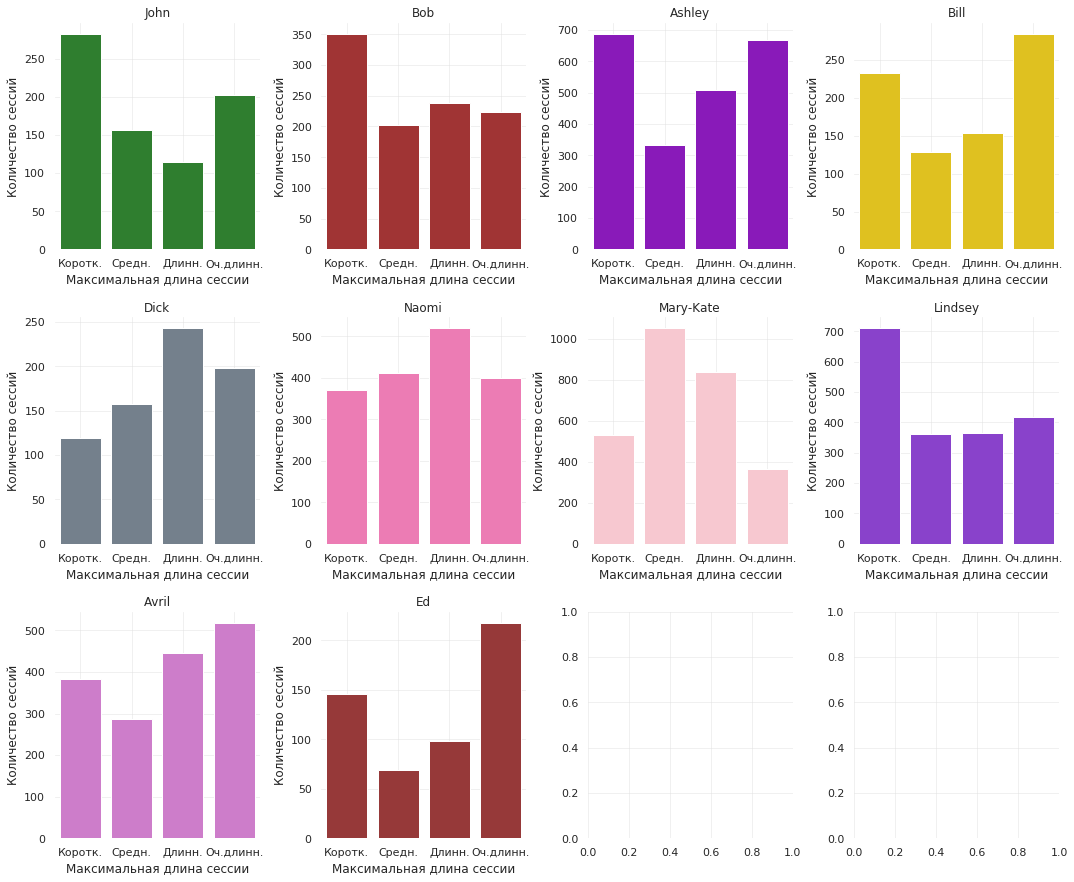

In [81]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in new_features_10users.target.unique()],
                             [new_features_10users.query('target == @t') for t in new_features_10users.target.unique()]):
    sns.countplot(pd.cut(sub_df.max_time, bins=bins, 
                         labels=['Коротк.', 'Средн.', 'Длинн.', 'Оч.длинн.']), 
                color=color_dic[user], ax=ax)
        
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('Максимальная длина сессии') 
    
plt.show()

#### Вывод: пользователи явно отличаются по максимальной длине сессии. Причем у кого-то короткие сессии преобладают, а у кого-то очень длинные, что навскидку кажется более подозрительным.

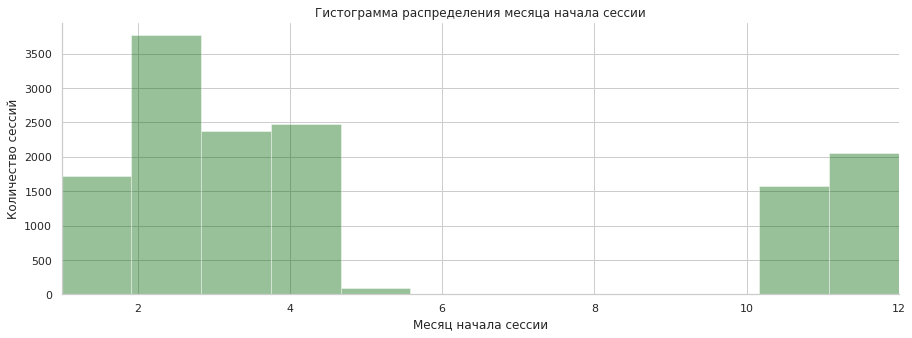

In [64]:
ax = sns.distplot(new_features_10users['month'], kde=False, color='darkgreen', bins=12)                

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Месяц начала сессии')  
ax.set_title('Гистограмма распределения месяца начала сессии')  # Title of the plot
plt.xlim(1, 12)

sns.despine()  # Get rid of axis on the plot

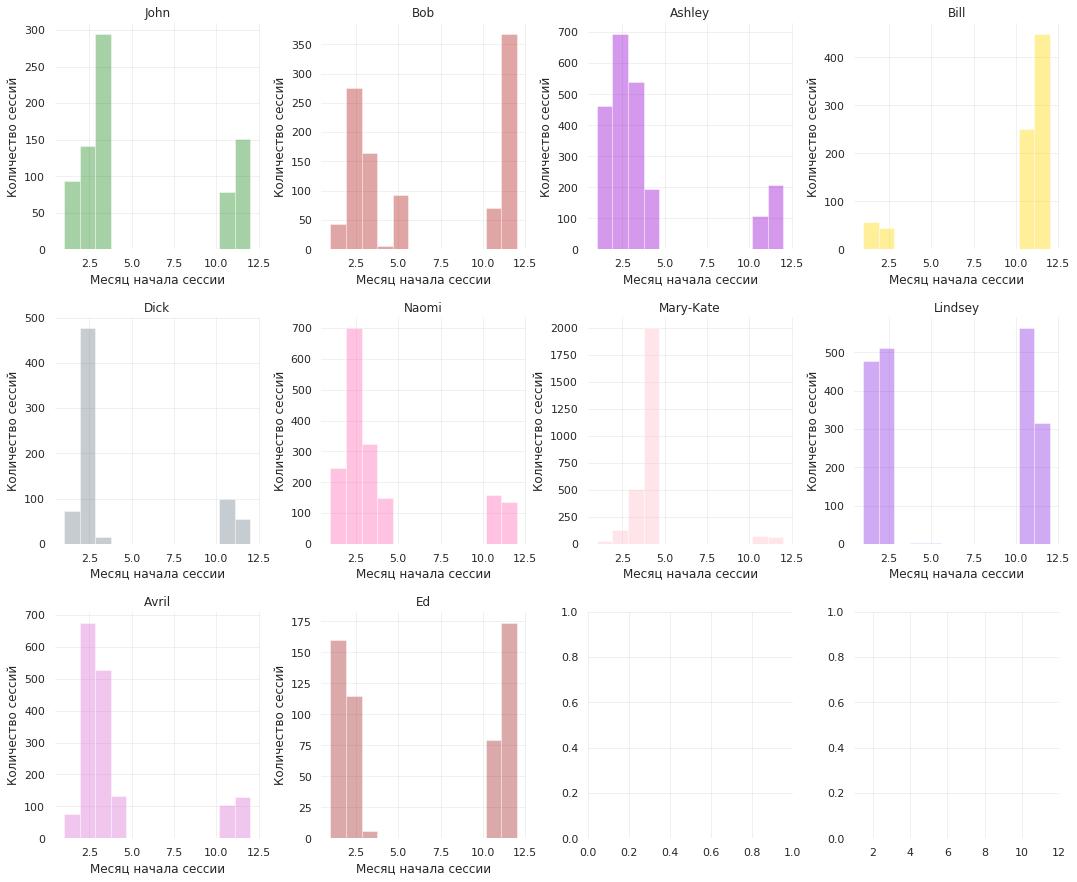

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in new_features_10users.target.unique()],
                             [new_features_10users.query('target == @t') for t in new_features_10users.target.unique()]):
    sns.distplot(sub_df['month'], kde=False, 
                color=color_dic[user], ax=ax, bins=12)
        
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.xlim(1, 12)

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('Месяц начала сессии') 
    
plt.show()

#### Вывод: месяцы распределены несколько хаотично, кажется какой-то особенной зависимости и выбросов нет. При этом сессии в месяцах 6-10 отсутствуют из-за особенностей данных. Думаю, можно исключить этот признак как непоказательный

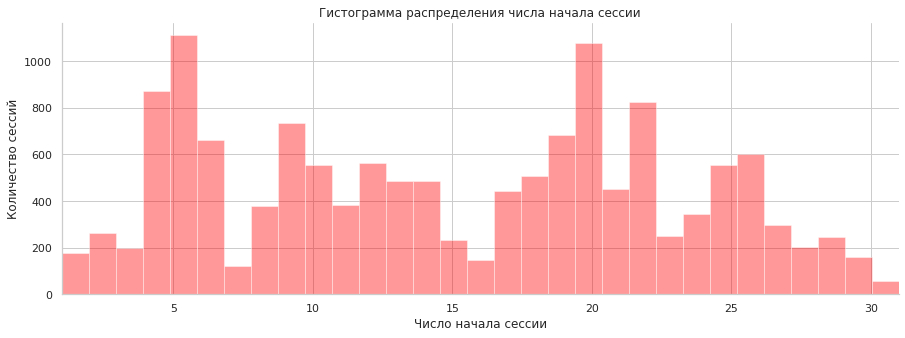

In [66]:
ax = sns.distplot(new_features_10users['day'], kde=False, color='red', bins=31)                

ax.set_ylabel('Количество сессий') 
ax.set_xlabel('Число начала сессии')  
ax.set_title('Гистограмма распределения числа начала сессии')  # Title of the plot
plt.xlim(1, 31)

sns.despine()  # Get rid of axis on the plot

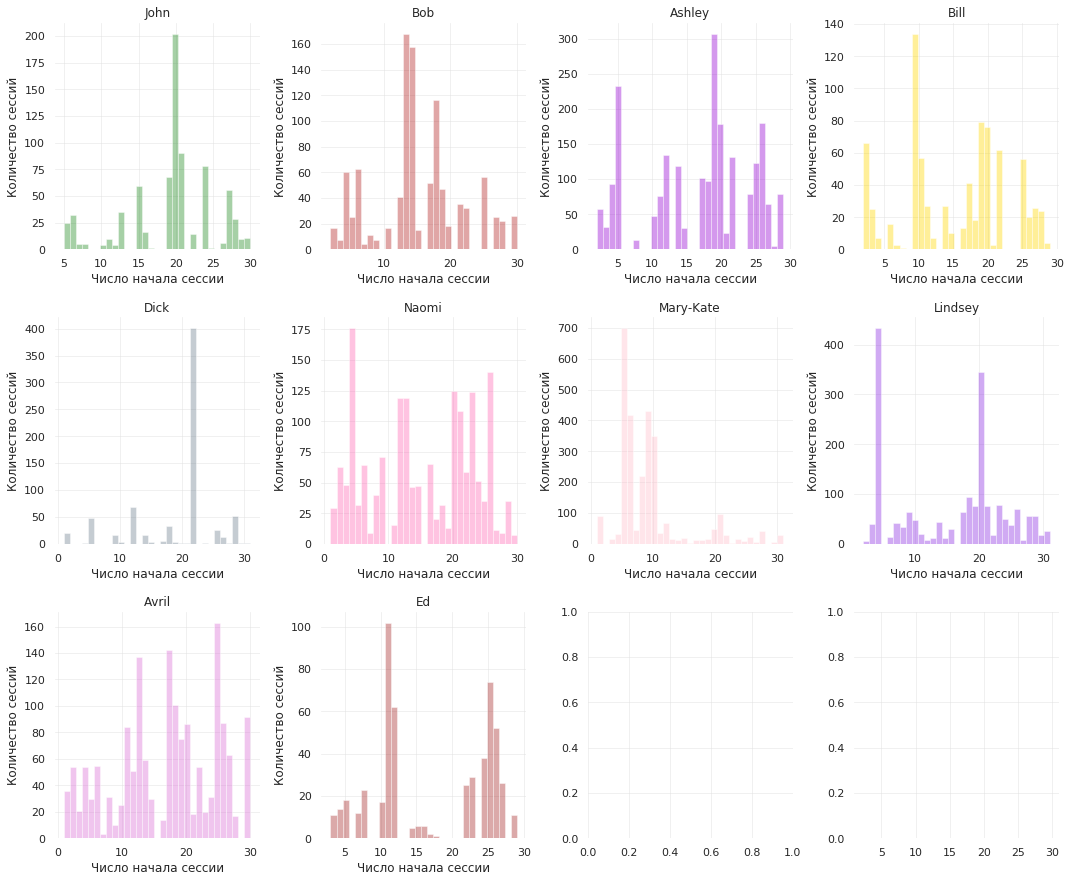

In [67]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 15))

# как вариант, можно и по-другому
for ax, user, sub_df in  zip(axes.flatten(),
                             [t for t in new_features_10users.target.unique()],
                             [new_features_10users.query('target == @t') for t in new_features_10users.target.unique()]):
    sns.distplot(sub_df['day'], kde=False, 
                color=color_dic[user], ax=ax, bins=31)
        
for ax in axes.flatten():
    # удаляем рамку
    ax.set_frame_on(False)  
    # делаем сетку графика совсем немного серой и наполовину прозрачной
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.xlim(1, 31)

for name, ax in zip(train_data_10users.target.unique(), axes.flatten()):
    ax.set(title='{}'.format(name))
    ax.tick_params(labelbottom=True, which='both')
    ax.set_ylabel('Количество сессий') 
    ax.set_xlabel('Число начала сессии') 
    
plt.show()

#### Вывод: для некоторых пользователей распределение более-менее равномерное, тогда как у других наблюдаются явные пики активности в определенные даты, в частости оклоло 10 и 20 числа

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [68]:
selected_features_10users = pd.concat([train_data_10users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']],
                                      new_features_10users.loc[:, ['youtube_visits', 'max_time', 'day']]], 
                                       axis=1)

In [69]:
selected_features_150users = pd.concat([train_data_150users.loc[:, ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']],
                                      new_features_150users.loc[:, ['youtube_visits', 'max_time', 'day']]], 
                                       axis=1)

In [70]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)